In [1]:
# load libraries
import utils as u
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
plt.rcParams.update({
    'axes.titlesize': 14,     # Title font size
    'axes.labelsize': 14,     # X and Y axis labels font size
    'xtick.labelsize': 12,    # X tick labels font size
    'ytick.labelsize': 12,    # Y tick labels font size
    'legend.fontsize': 14,    # Legend font size
    'figure.titlesize': 14    # Figure title font size
})

# Load the data

In [3]:
import pickle as pkl

# load the stored data
file_name = 'sec2_data_output.pkl'

with open(file_name, 'rb') as f:
    data = pkl.load(f)

wl = data['wavelength']
df = data['df']

In [4]:
df.columns

Index(['manga_id', 'teff', 'teff_err', 'logg', 'logg_err', 'feh', 'feh_err',
       'flux', 's2n', 'teff_class', 'teff_label', 'logg_label', 'feh_class',
       'feh_label'],
      dtype='object')

In [5]:
X = np.stack(df['flux'].values, axis=0)

y_t = np.array(df['teff_label']).astype('int')
y_g = np.array(df['logg_label']).astype('int')
y_m = np.array(df['feh_label']).astype('int')

# Feature selection

In [6]:
print('Wavelength range: {:.2f}  {:.2f}'.format(wl[0], wl[-1]))

spec_size = X[0].shape[0]

print('Number of values per spectrum:', spec_size)

Wavelength range: 3621.60  10353.81
Number of values per spectrum: 4563


   **Lines to be selected**
   
   1. He I 3889 Å
   2. Ca II K (3934 Å)
   3. Ca II H (3968 Å)
   4. H-delta (4101.7 Å)
   5. Ca I 4227 Å
   6. G Band of CH around 4300 Å
   7. H-gamma (4340.5 Å)
   8. Fe I 4384 Å
   9. He I 4471 Å
   10. He II 4686 Å
   11. H-beta (4861.3 Å)
   12. Fe II 4920 Å
   13. Fe II 5018 Å
   14. Fe II 5169 Å
   15. Fe I 5270 Å
   16. He II 5411 Å
   17. He I 5876 Å
   18. Na I 5890 - 5896 Å
   19. Fe I 6173 Å
   20. TiO Band 6200 - 6300 Å
   21. H-alpha (6562.8 Å)
   22. TiO Band 6700 - 6900 Å

In [7]:
spec_lines = {'line_wl':
    [3889, 3934, 3968, 4101.7, 4227, 4300, 4340.5, 4384, 4471, 4686, 4861.3, 4920, 5018, 5169, 5270, 5411, 5876, 5893, 6173, 6250, 6562.8, 6800],
              'bounds':
    [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 58, 8, 108]}

new_X = u.select_features(X, wl, spec_lines['line_wl'][0])
for i in range(1, len(spec_lines['line_wl'])):
    print(f"Line {i+1} of {len(spec_lines['line_wl'])}, Current shape: {new_X.shape}", end="\r")
    new_X = np.concatenate((new_X, u.select_features(X, wl, spec_lines['line_wl'][i], spec_lines['bounds'][i])), axis=1)
print(f"\nFinal shape: {new_X.shape}")

Line 22 of 22, Current shape: (59085, 457)
Final shape: (59085, 674)


# PCA plot

This is only done to plot the PCA plot and choose the number of features. Neither the scaler nor the PCA object fitted using the entire dataset are used later. New scalers are fitted using only training sets to transfrom the data.

In [8]:
scaler = MinMaxScaler()
# fit the scaler and transform the data
X_scaled = scaler.fit_transform(new_X)

In [9]:
pca = PCA(n_components=X_scaled.shape[1])
# fit the PCA object and transform the data
X_pca = pca.fit_transform(X_scaled)

In [10]:
n_comp = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.999)[0][0] + 1
print(f"More than 99.9% of the variance in the data is explained by {n_comp} PCA components.")

More than 99.9% of the variance in the data is explained by 9 PCA components.


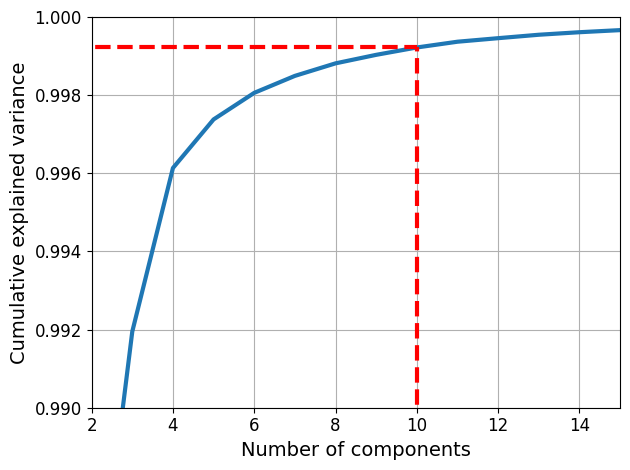

In [18]:
y_pca = np.cumsum(pca.explained_variance_ratio_)[9]

plt.plot(range(1,21), np.cumsum(pca.explained_variance_ratio_)[:20], linewidth=3)
plt.plot([10,10], [0.88, y_pca], color='red', linestyle='--', linewidth=3)
plt.plot([1,10], [y_pca, y_pca], color='red', linestyle='--', linewidth=3)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.ylim(0.99,1)
plt.xlim(2,15)
plt.grid(True)

plt.tight_layout()

plt.savefig('PCA.pdf');

# Preprocess and save data files

In [12]:
# t_eff
u.preprocess_set(new_X, y_t, 'teff')

Data saved in file sec3_1_data_output_teff.pkl


In [13]:
# log g
u.preprocess_set(new_X, y_g, 'logg')

Data saved in file sec3_1_data_output_logg.pkl


In [14]:
# [Fe/H]
u.preprocess_set(new_X, y_m, 'feh')

Data saved in file sec3_1_data_output_feh.pkl
